In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from nltk.corpus import stopwords
import seaborn as sns
import wo
import pickle
import os

ModuleNotFoundError: No module named 'wordcloud'

In [2]:
training_df = pd.read_csv('resources/training.csv')

In [3]:
words = pd.read_csv('resources/vocabulary.txt', delimiter='\t', header=None)

In [38]:
scaler = MinMaxScaler()
stop_words = set(stopwords.words('english'))

x = training_df.iloc[:, 1:-1].values # doc vector data
y = training_df.iloc[:, -1].values # labels

# Find stopword indices
stopword_indices = []
for i, word in enumerate(words[0]):
    if word in stop_words:
        stopword_indices.append(i)

# Remove stopword indices from x
x = np.delete(x, stopword_indices, axis=1)

x = scaler.fit_transform(x)
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.2)

In [12]:
class NaiveBayesClassifier:

    def __init__(self, alpha=1):
        self.alpha = alpha
        self.log_prior = None
        self.log_likelihood = None

    def fit(self, X, y):
        # Estimate P(Y) using MLE
        self.classes, class_counts = np.unique(y, return_counts=True)
        self.log_prior = np.log(class_counts / y.shape[0])
        # Estimate P(X|Y) using MAP with prior
        V = X.shape[1]
        self.log_likelihood = np.zeros((len(self.classes), V))
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            # Add alpha to each count for smoothing
            word_counts = abs(X_c.sum(axis=0) + self.alpha)
            total_counts = abs(word_counts.sum() + 1e-9)
            self.log_likelihood[i, :] = np.log(word_counts / total_counts)

    def predict(self, x_new):
        # Calculate probabilities for each class
        log_probs = np.zeros(len(self.classes))
        for i, c in enumerate(self.classes):
            log_probs[i] = self.log_prior[i] + \
                (self.log_likelihood[i, :] * x_new).sum()

        # Return the class with the highest probability
        return self.classes[np.argmax(log_probs)]

    def find_accuracy(original_df, pred_df):
        num_correct = 0
        index = 0
        for _, doc in pred_df.iterrows():
            if (doc['pred'] == original_df.iloc[index, -1]):
                num_correct += 1
            index += 1

        return num_correct/len(original_df)


In [26]:
accuracies = []
betas = np.linspace(0.00001, 1, num=10)
p = np.linspace(0.00001, 1, num=10)
alphas = p + betas

for a in alphas:
    model = NaiveBayesClassifier(alpha=a)
    model.fit(x_train, y_train)
    y_pred = np.array([int(model.predict(x)) for x in x_validation]).tolist()
    acc = accuracy_score(y_validation, y_pred)
    accuracies.append(acc)

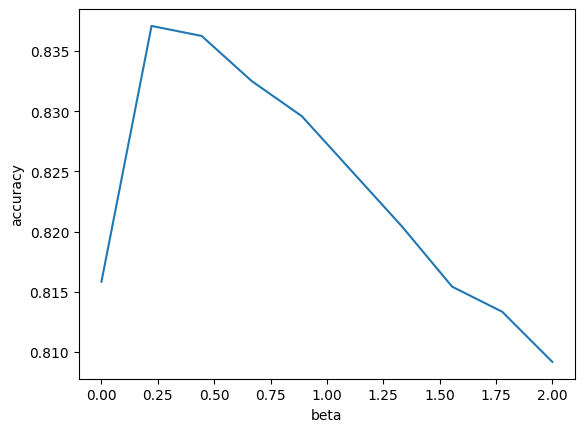

<Figure size 640x480 with 0 Axes>

In [27]:
# plot accuracy for values of beta and alpha
plt.plot(alphas, accuracies)
plt.xlabel('alphas')
plt.ylabel('accuracy')
plt.show()
plt.savefig('nb.png')


In [13]:
if os.path.isfile('resources/naive_bayes_model.pkl'):
  # Load the saved model from the file
  with open('resources/naive_bayes_model.pkl', 'rb') as file:
    nb = pickle.load(file)

else:
  nb = NaiveBayesClassifier()
  nb.fit(x_train, y_train)

  # Save the trained model to a file
  with open('resources/naive_bayes_model.pkl', 'wb') as file:
    pickle.dump(nb, file)

In [14]:
validation_preds = np.array([nb.predict(x) for x in x_validation])
accuracy = np.mean(validation_preds == y_validation)
print(accuracy)

0.8275


In [8]:
testing_df = pd.read_csv('resources/testing.csv')

In [9]:
x_test = testing_df.iloc[:, 1:].values

# Remove stopword indices from x
x_test = np.delete(x_test, stopword_indices, axis=1)

x_test = scaler.fit_transform(x_test)

In [10]:
test_preds = np.array([int(nb.predict(x)) for x in x_test]).tolist()
ids = list(testing_df.iloc[:, :1].values)

if int(ids[0][0]) != 12001:
    ids.insert(0, np.array([12001]))
    test_preds.insert(0, 9)

In [11]:
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'class'])

    for id, pred in zip(ids, test_preds):
        writer.writerow([id[0], pred])

In [33]:
classes = np.unique(y_validation, return_counts=False)
cm = confusion_matrix(y_validation, validation_preds, labels=classes)

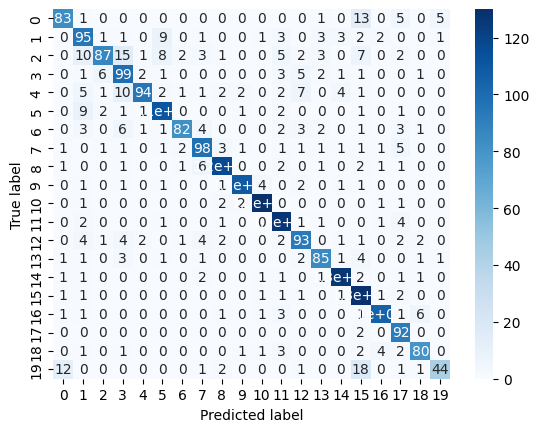

In [36]:
# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Ranking words

<sub>Sources:<br>
https://en.wikipedia.org/wiki/Mutual_information<br>
https://towardsdatascience.com/select-features-for-machine-learning-model-with-mutual-information-534fe387d5c8
</sub>

In [15]:
def mutual_information(x, y, words, penalty=0.5):
    n_samples, n_features = x.shape
    n_classes = len(np.unique(y))

    # Compute the frequency of each word in each class
    word_freq = np.zeros((n_features, n_classes))
    for i in range(n_classes):
        X_class = x[y == i, :]
        word_freq[:, i] = np.sum(X_class, axis=0)

    # Compute the total number of documents in each class and the total number of documents
    class_freq = np.sum(word_freq, axis=0)
    total_freq = np.sum(class_freq)

    # Compute the MI between each word and each class
    mi_scores = np.zeros(n_features)
    for j in range(n_features):
        n_j = np.sum(x[:, j] > 0)
        for i in range(n_classes):
            n_ij = word_freq[j, i]
            if n_ij == 0:
                continue
            p_ij = n_ij / n_samples
            p_i = class_freq[i] / n_samples
            p_j = n_j / n_samples
            mi_scores[j] += p_ij * np.log2(p_ij / (p_i * p_j))

    # Normalize the MI scores to have a range of [0, 1]
    mi_scores_norm = (mi_scores - np.min(mi_scores)) / \
        (np.max(mi_scores) - np.min(mi_scores))

    return mi_scores_norm


In [16]:
word_values = words.iloc[:, 0].values
mi = mutual_information(x_train, y_train, word_values, penalty=0.8)

In [51]:
# print table of 5 most informative and 5 least informative words
print('Most Informative Words')
print(words.iloc[np.argsort(mi)[-5:]])
print('\nLeast Informative Words')
print(words.iloc[np.argsort(mi)[:5]])

with open('results/most_informative_words.txt', 'w') as file:
    for i in range(100):
        file.write(words.iloc[np.argsort(mi)[-i-1]][0] + '\n')

# output to txt file, for each word, output the word i times, where i is the index of the word in the sorted list. This will be used to create a word cloud
with open('resources/word_cloud.txt', 'w') as file:
    for i in range(100):
        for j in range(100 - i):
            file.write(words.iloc[np.argsort(mi)[-i-1]][0] + ' ')

Most Informative Words
              0
22358  edgeways
27916    buffet
56448    usally
27661      olds
27920       gew

Least Informative Words
               0
705         less
697  kierkegaard
909        admit
247     canticle
34           box


In [29]:
threshold = 0.5
x_train = x_train[:, mi > threshold]
x_validation = x_validation[:, mi > threshold]
x_test = x_test[:, mi > threshold]

# Train a new Naive Bayes model with the reduced feature set
nb = NaiveBayesClassifier(alpha=0.22224)
nb.fit(x_train, y_train)

# predict on test set
test_preds = np.array([int(nb.predict(x)) for x in x_test]).tolist()

# write predictions to file
if int(ids[0][0]) != 12001:
    ids.insert(0, np.array([12001]))
    test_preds.insert(0, 9)

In [31]:
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'class'])

    for id, pred in zip(ids, test_preds):
        writer.writerow([(id[0] + 1), pred])